In [1]:
import numpy as np
from tdse_solver import *
from helper import *

### Variable

**System & Potential**
- `a`: lattice constant
- `v0`: potential strength
- `b`: reciprocal lattice vector, $b = \frac{2\pi}{a}$
- `Vx`: total potential, $V_x = 2v_0 \cos(bx) -qEx$

**Force & Time**
- `qE`: external force
- `dt`: time step (time interval of simulation)
- `Tbloch`: bloch period, $T_B = \frac{2\pi}{qE \cdot a}$, spse $\hbar=1$
- `NSW`: number of steps, total number of simulation steps (we set it as `6 * Tbloch`)

**Numerical & Basis**
- `ngx`:
    - number of G-vectors
    - number of basis that for plane wave expansion
    - the higher value, the more precise energy calculation becomes
- `nbnds`: number of bands to calculate
- `Gx`: 
    - integer index array of reciprocal lattice vector
    - it is used to construct the plane wave basis $e^{i(k+G)x}$

**Spatial Grid**
- `Nc`: number of cells, contained in simulation domain
- `Nx`: grid points, discretize the space into system of gird points
- `L`: total length, $L = N_c \times a$
- `x`: coordinate space

**Wavefunction & Band Structure**
- `k0_center`: center crystal momentum of the initial Gaussian wavepacket
- `sigma_k`: width (spread) of the wavepacket in k-space
- `kwp`: array of k-points sampled for the wavepacket construction
- `fk`: Gaussian envelope coefficients (weights) corresponding to `kwp`
- `bloch_wp`: initial wavefunction at $t=0$ constructed by superposition of bloch states
- `k_1d_bz`: array of k-values discretizing the 1st Brillouin Zone ,$-\pi/a \sim \pi/a$
- `Enk`: energy eigenvalues for each k (band structure)
- `phi_nk`: bloch eigenstates corresponding to each k
- `PSI0`: computed time-dependent wavefunction $\psi(x,t)$


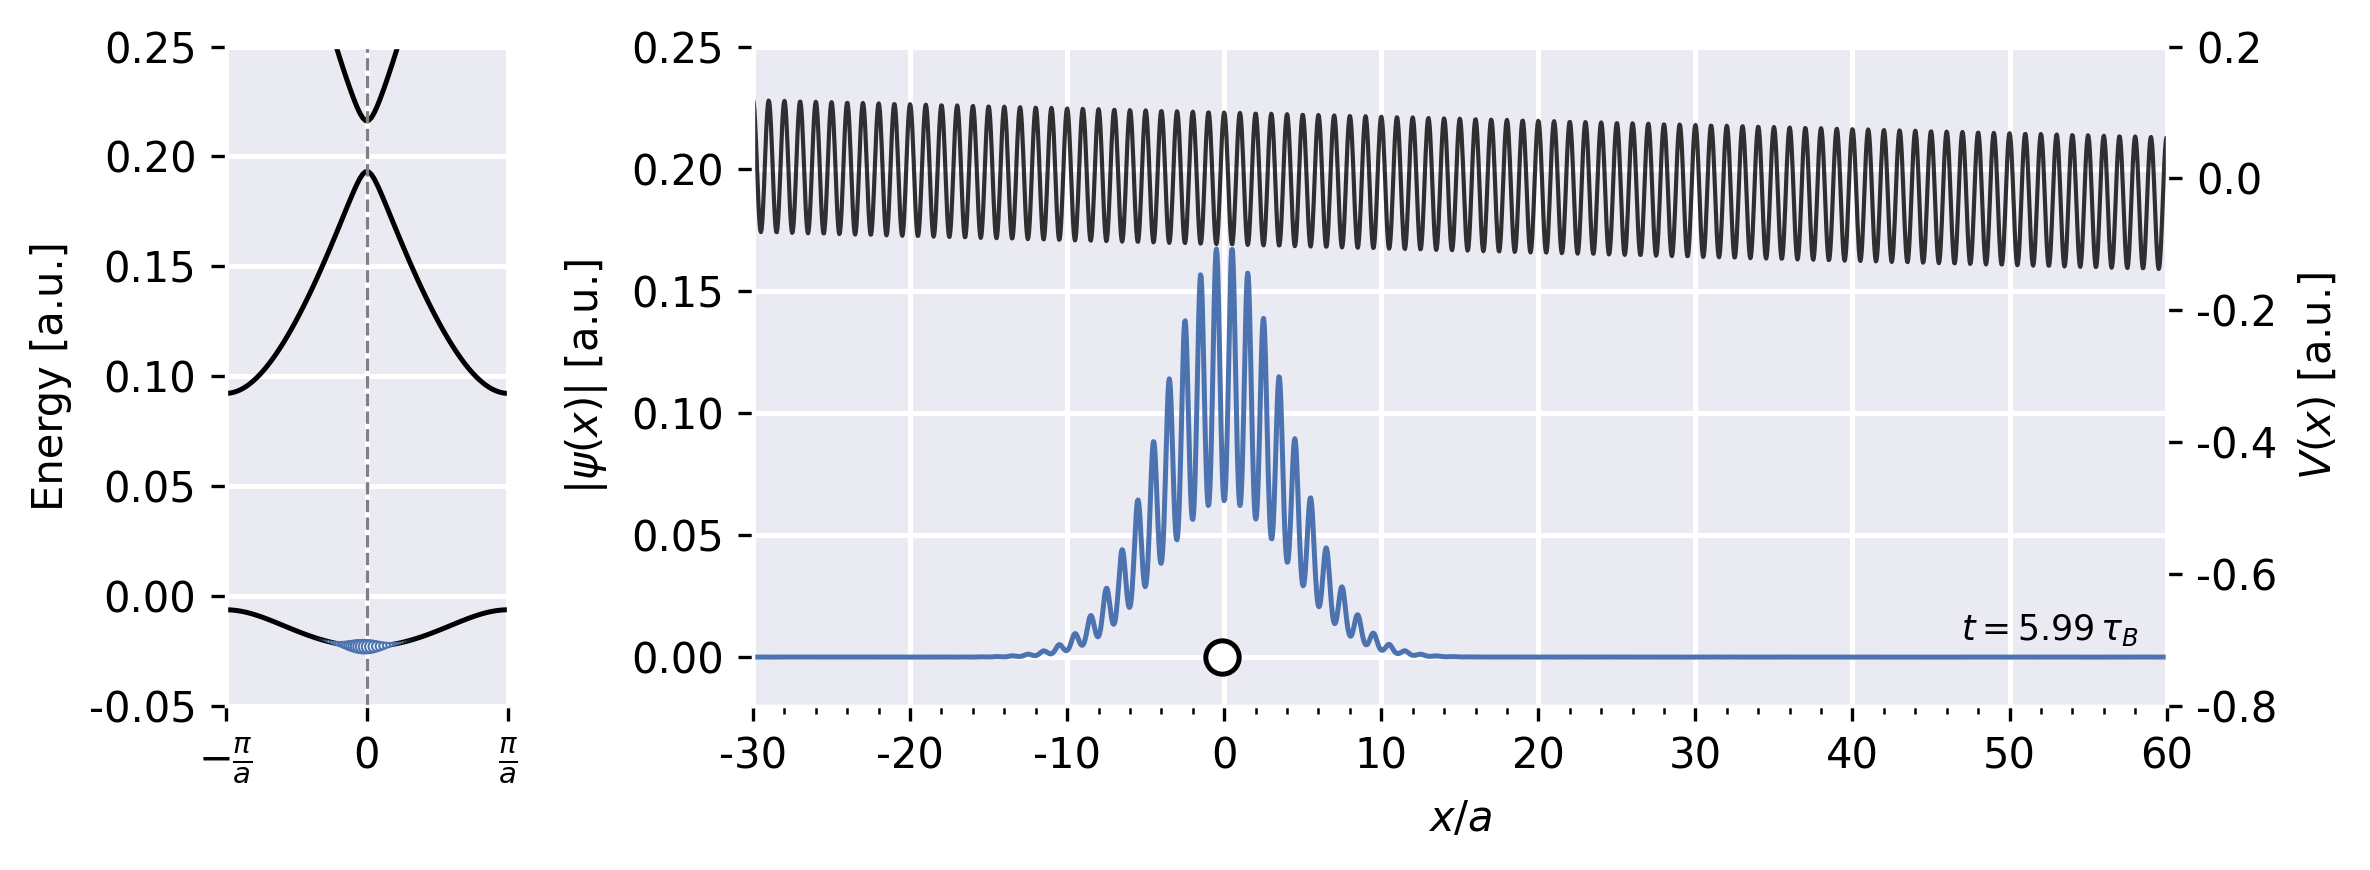

Animation saved to ../simulation/bch_osc_tdse_ssfm.mp4 (600 frames, ~24.0s)


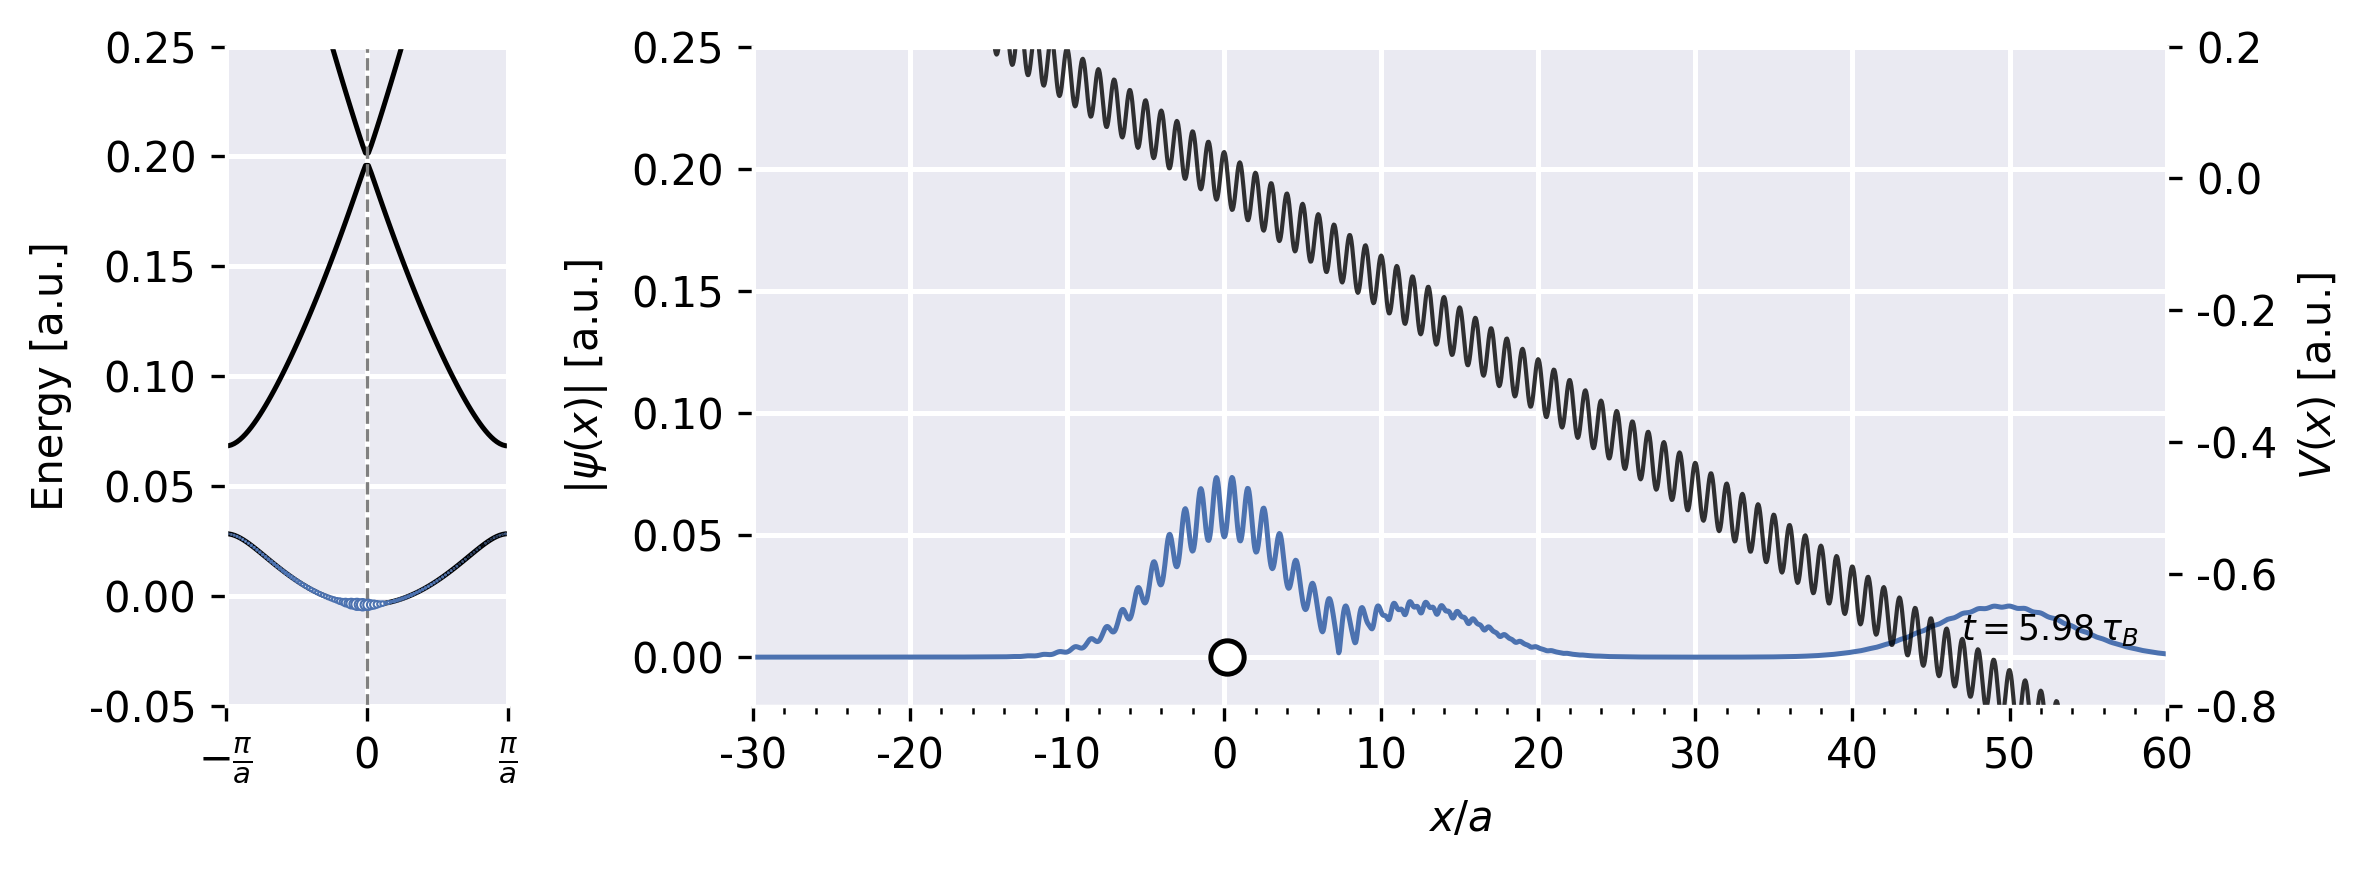

Animation saved to ../simulation/bch_osc_tdse_ssfm_zener.mp4 (599 frames, ~24.0s)


In [2]:
def run_bloch_simulation(a, v0, qE, dt, ngx, nbnds, k0_center, sigma_k, 
                         Nc, Nx, x_range, n_periods, solver, filename, frame_skip, fps=25):
    b = 2 * np.pi / a
    Tbloch = 2 * np.pi / (qE * a)
    L = Nc * a
    
    x = np.linspace(x_range[0] * L, x_range[1] * L, Nx)
    Vx = 2 * v0 * np.cos(b * x) - qE * x
    
    kwp, fk = get_bloch_wavepacket_gaussian_envelop(k0_center, sigma_k=sigma_k, nk=100, Nsigma=10)
    bloch_wp = construct_blochwp_cosx_pot(x, kwp, fk, a=a, v0=v0, nbnds=nbnds, ngx=ngx)
    
    k_1d_bz = np.linspace(-0.5, 0.5, 100)
    Gx = np.arange(ngx, dtype=int)
    Gx[ngx // 2 + 1:] -= ngx
    
    Enk, phi_nk = [], []
    for k in k_1d_bz:
        e, c = epsilon_nk_cosx_pot(k, a=a, v0=v0, ngx=ngx, nbnds=nbnds, Ngmax=1)
        Enk.append(e)
        phi_nk.append(np.sum(c[0][:, None] * np.exp(1j * b * (Gx + k)[:, None] * x[None, :]), axis=0))
    
    Enk, phi_nk = np.asarray(Enk), np.asarray(phi_nk)
    
    NSW = n_periods * int(Tbloch / dt)
    PSI0 = solver(bloch_wp, Vx, x, dt, NSW, False)
    
    create_bloch_animation(
        PSI0, Enk, phi_nk, Vx, x, k_1d_bz,
        params={'a': a, 'dt': dt, 'Tbloch': Tbloch, 'n0': 0, 'nbnds': nbnds},
        filename=filename,
        frame_skip=frame_skip,
        fps=fps
    )


# Bloch Oscillation (weak field, no Zener tunneling)
run_bloch_simulation(
    a=10, v0=0.05, qE=2*np.pi/1E5, dt=1,
    ngx=20, nbnds=5, k0_center=0, sigma_k=0.04,
    Nc=150, Nx=3999, x_range=(-0.4, 0.6), n_periods=6,
    solver=SplitStepFourier,
    filename='../simulation/bch_osc_tdse_ssfm.mp4',
    frame_skip=100
)

# Bloch Oscillation with Zener Tunneling (strong field)
run_bloch_simulation(
    a=10, v0=0.02, qE=2*np.pi/4000, dt=0.1,
    ngx=20, nbnds=5, k0_center=0, sigma_k=0.04,
    Nc=150, Nx=7999, x_range=(-0.4, 2.0), n_periods=6,
    solver=SplitStepFourier,
    filename='../simulation/bch_osc_tdse_ssfm_zener.mp4',
    frame_skip=40
)